In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import string
from sklearn.feature_extraction.text import CountVectorizer
import random
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

2023-09-22 07:12:13.841752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 07:12:13.898666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 07:12:13.899786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 07:12:16.019566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to
[nltk_data]     /home/7d515a27-500e-49a7-accc-
[nltk_data]     3e4f4339db24/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/7d515a27-500e-49a7-accc-
[nltk_data]

In [3]:
# Definition to import datset as dataframe
def createDF(path, source):
    labels, texts = [],[]
    for i, line in enumerate((open(path).read()).split('\n')):
        content = line.split('\t')
        if len(content) > 1:
            texts.append(content[0])
            labels.append(content[1])
    df = pd.DataFrame()
    df['label'] = labels
    df['text'] = texts
    df['source'] = source
    return df

In [4]:
# Import datasets into dataframes 
amazon_df = createDF('D213 Part 2/amazon_cells_labelled.txt', 'amazon')
imdb_df = createDF('D213 Part 2/imdb_labelled.txt', 'imdb')
yelp_df = createDF('D213 Part 2/yelp_labelled.txt', 'yelp')

In [5]:
# Display datasets
display(amazon_df.head())
display(amazon_df.shape)
display(imdb_df.head())
display(imdb_df.shape)
display(yelp_df.head())
display(yelp_df.shape)

,label,text,source
0,0,So there is no way for me to plug it in here i...,amazon
1,1,"Good case, Excellent value.",amazon
2,1,Great for the jawbone.,amazon
3,0,Tied to charger for conversations lasting more...,amazon
4,1,The mic is great.,amazon


(1000, 3)

,label,text,source
0,0,"A very, very, very slow-moving, aimless movie ...",imdb
1,0,Not sure who was more lost - the flat characte...,imdb
2,0,Attempting artiness with black & white and cle...,imdb
3,0,Very little music or anything to speak of.,imdb
4,1,The best scene in the movie was when Gerardo i...,imdb


(1000, 3)

,label,text,source
0,1,Wow... Loved this place.,yelp
1,0,Crust is not good.,yelp
2,0,Not tasty and the texture was just nasty.,yelp
3,1,Stopped by during the late May bank holiday of...,yelp
4,1,The selection on the menu was great and so wer...,yelp


(1000, 3)

In [6]:
# Concatenate datasets
df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index = True)

In [7]:
df

,label,text,source
0,0,So there is no way for me to plug it in here i...,amazon
1,1,"Good case, Excellent value.",amazon
2,1,Great for the jawbone.,amazon
3,0,Tied to charger for conversations lasting more...,amazon
4,1,The mic is great.,amazon
...,...,...,...
2995,0,I think food should have flavor and texture an...,yelp
2996,0,Appetite instantly gone.,yelp
2997,0,Overall I was not impressed and would not go b...,yelp
2998,0,"The whole experience was underwhelming, and I ...",yelp


In [8]:
# Describe dataframe
df['chars'] = df.text.apply(len)
df['words'] = df.text.apply(lambda x: len(x.split()))
df['avg_word_len'] = df['chars']/df['words']
df['punctuation'] = df.text.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
df['uppercase'] = df.text.apply(lambda x: len([word for word in x.split() if word.isupper]))
df['titles'] = df.text.apply(lambda x: len([word for word in x.split() if word.istitle]))
df.head()

,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4


In [9]:
# Determine if any replicated responses
df['text'].value_counts()

Great phone.                                                                                                                              2
Not recommended.                                                                                                                          2
Works great.                                                                                                                              2
I won't be back.                                                                                                                          2
I love this place.                                                                                                                        2
                                                                                                                                         ..
The Songs Were The Best And The Muppets Were So Hilarious.                                                                                1
It Was So Cool.     

In [10]:
# Determine unique responses
df['text'].unique()

array(['So there is no way for me to plug it in here in the US unless I go by a converter.',
       'Good case, Excellent value.', 'Great for the jawbone.', ...,
       'Overall I was not impressed and would not go back.',
       "The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",
       "Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check."],
      dtype=object)

In [11]:
# Determine min and max length responses
print(min(df['text'].str.len()))
print(max(df['text'].str.len()))

7
479


In [12]:
# Determine count of unique words
cnt_vect = CountVectorizer()
features_vect_df = cnt_vect.fit(df.text)
features_df = features_vect_df.get_feature_names_out()
print('df total number of unique words:', len(features_df))

df total number of unique words: 5155


In [13]:
# Sample of unique 
random.sample(list(features_df), 10)

['commands',
 'ass',
 'securly',
 'few',
 'cuts',
 'documentary',
 'confuses',
 'phones',
 'tremendous',
 'rolled']

In [14]:
# Unique word matrix
features_vect_df_trans = cnt_vect.transform(df.text)
type(features_vect_df_trans)

scipy.sparse._csr.csr_matrix

In [15]:
# Count of matrix values
features_vect_df_trans.getnnz()

31578

In [16]:
print("Density of matrix: ", features_vect_df_trans.getnnz()*100/(features_vect_df_trans.shape[0]*features_vect_df_trans.shape[1]))

Density of matrix:  0.20419010669253151


In [17]:
# Create training Dataframe
train_df = pd.DataFrame(features_vect_df_trans.todense())
train_df.columns = features_df
train_df[0:1]

,00,10,100,11,12,13,15,15g,15pm,17,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.text[0:1]

0    So there is no way for me to plug it in here i...
Name: text, dtype: object

In [19]:
# Create dataframe with count
features_cnt = np.sum(features_vect_df_trans.toarray(), axis = 0)
features_cnt_df = pd.DataFrame(dict(features_df = features_df, counts = features_cnt))

(array([5.108e+03, 2.700e+01, 8.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

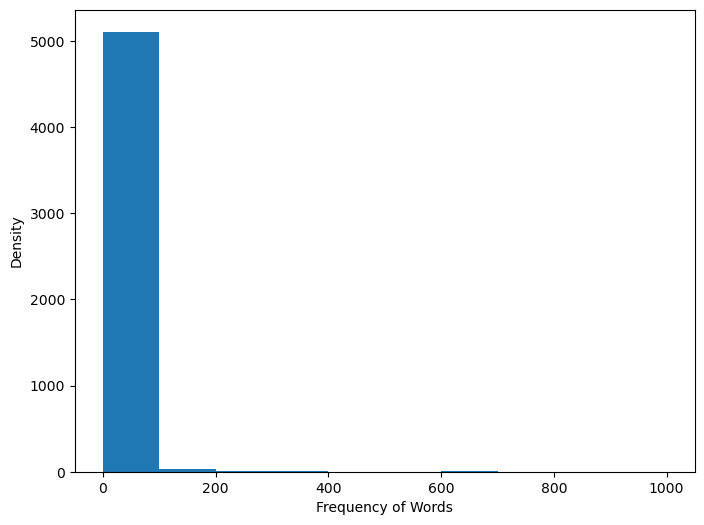

In [20]:
# Plot histogram
plt.figure(figsize = (8,6))
plt.xlabel('Frequency of Words')
plt.ylabel('Density')
plt.hist(features_cnt_df.counts, bins = 10, range = (0, 1000))

In [21]:
# Count of words that do not repeat
len(features_cnt_df[features_cnt_df.counts == 1])

2918

In [22]:
cnt_vect = CountVectorizer(max_features = 3000)
features_vect = cnt_vect.fit(df.text)
features = features_vect.get_feature_names_out()
train_df_features = cnt_vect.transform(df.text)
features_cnts = np.sum(train_df_features.toarray(), axis = 0)
features_cnts = pd.DataFrame(dict(features = features, counts = features_cnts))
features_cnts.sort_values('counts', ascending = False)[0:15]

,features,counts
2377,the,1953
85,and,1138
1036,it,789
1033,is,754
2455,to,670
2404,this,643
1334,of,624
2814,was,571
1005,in,400
801,for,336


<Axes: xlabel='label', ylabel='awesome'>

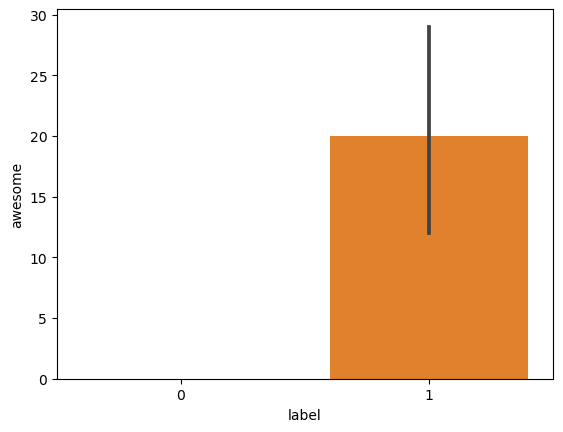

In [23]:
# Plot density of positive word
train_df = pd.DataFrame(train_df_features.todense())
train_df.columns = features
train_df['label'] = df.label
sns.barplot(x = 'label', y = 'awesome', data = train_df, estimator = sum)

<Axes: xlabel='label', ylabel='hate'>

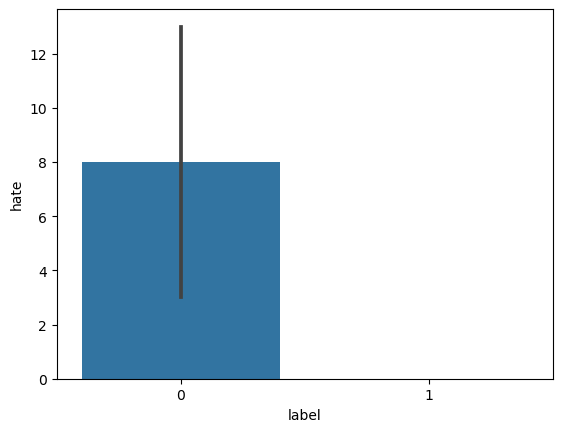

In [24]:
# Plot density of negative word
train_df = pd.DataFrame(train_df_features.todense())
train_df.columns = features
train_df['label'] = df.label
sns.barplot(x = 'label', y = 'hate', data =train_df, estimator = sum)

In [25]:
df

,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4
...,...,...,...,...,...,...,...,...,...
2995,0,I think food should have flavor and texture an...,yelp,66,12,5.500000,1,12,12
2996,0,Appetite instantly gone.,yelp,24,3,8.000000,1,3,3
2997,0,Overall I was not impressed and would not go b...,yelp,50,10,5.000000,1,10,10
2998,0,"The whole experience was underwhelming, and I ...",yelp,91,16,5.687500,3,16,16


In [26]:
# Review statistics
display(df.groupby(['source', 'label']).describe().loc[:, (slice(None), ['mean', 'std'])].reset_index())
display(df.groupby(['source', 'label']).describe().loc[:, (slice(None), ['min', 'max'])].reset_index())

source label   chars              words            avg_word_len            \
                   mean        std    mean        std         mean       std   
0  amazon     0  56.824  34.022464  10.578   6.578028     5.653474  1.262250   
1  amazon     1  53.628  35.234764   9.914   6.785772     5.670933  1.113802   
2    imdb     0  77.088  50.887753  13.582   9.036293     5.811760  0.942026   
3    imdb     1  87.456  60.820773  15.128  10.102859     5.826515  0.992945   
4    yelp     0  60.750  34.224935  11.498   6.611916     5.401276  0.896919   
5    yelp     1  55.882  30.228390  10.290   5.831459     5.606414  0.951573   

  punctuation           uppercase             titles             
         mean       std      mean        std    mean        std  
0       2.002  1.509488    10.578   6.578028  10.578   6.578028  
1       1.842  1.296301     9.914   6.785772   9.914   6.785772  
2       2.494  1.954893    13.582   9.036293  13.582   9.036293  
3       2.650  2.282525    15.128  10.102859  15.128  10.102859  
4       2.000  1.424098    11.498   6.611916  11.498   6.611916  
5       1.930  1.658494    10.290   5.831459  10.290   5.831459

source label chars        words       avg_word_len       punctuation        \
                  min    max   min   max          min   max         min   max   
0  amazon     0  11.0  149.0   1.0  30.0     3.857143  14.0         0.0  11.0   
1  amazon     1  11.0  148.0   1.0  30.0     3.166667  13.0         0.0   9.0   
2    imdb     0   8.0  321.0   1.0  56.0     4.181818  11.5         1.0  14.0   
3    imdb     1   7.0  479.0   1.0  71.0     3.200000  12.0         0.0  18.0   
4    yelp     0  11.0  149.0   2.0  32.0     3.666667  12.5         0.0  11.0   
5    yelp     1  11.0  148.0   1.0  32.0     3.666667  11.0         0.0  19.0   

  uppercase       titles        
        min   max    min   max  
0       1.0  30.0    1.0  30.0  
1       1.0  30.0    1.0  30.0  
2       1.0  56.0    1.0  56.0  
3       1.0  71.0    1.0  71.0  
4       2.0  32.0    2.0  32.0  
5       1.0  32.0    1.0  32.0

In [27]:
df

,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4
...,...,...,...,...,...,...,...,...,...
2995,0,I think food should have flavor and texture an...,yelp,66,12,5.500000,1,12,12
2996,0,Appetite instantly gone.,yelp,24,3,8.000000,1,3,3
2997,0,Overall I was not impressed and would not go b...,yelp,50,10,5.000000,1,10,10
2998,0,"The whole experience was underwhelming, and I ...",yelp,91,16,5.687500,3,16,16


In [28]:
# Split the words into tokens
i = 0
df['clean_text'] = ''
for row in df.text:
    # Add spaces after punctuation
    row = row.replace('.', '. ', row.count('.')).replace(',', ', ',row.count(','))
    # Tokenize words 
    tokens = word_tokenize(row)
    # Make all words lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    # Remove numbers
    words = [token.translate(table) for token in tokens]
    # Filter stopwords
    words = [word for word in words if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    df['clean_text'][i] = ' '.join(words)
    i += 1
df.clean_text = df.source + ' ' + df.clean_text
df.head()

/tmp/ipykernel_3674/3478022845.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'][i] = ' '.join(words)


,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles,clean_text
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21,amazon way plug us unless go converter
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4,amazon good case excellent value
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4,amazon great jawbone
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11,amazon tied charger conversations lasting 45 m...
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4,amazon mic great


In [29]:
# Add column of count of clean words
df['clean_words'] = df.clean_text.apply(lambda x: len(x.split()))
df.head()

,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles,clean_text,clean_words
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21,amazon way plug us unless go converter,7
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4,amazon good case excellent value,5
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4,amazon great jawbone,3
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11,amazon tied charger conversations lasting 45 m...,9
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4,amazon mic great,3


In [30]:
print(min(df['clean_words']))
print(max(df['clean_words']))

2
42


In [31]:
features_vect_df2 = cnt_vect.fit(df.clean_text)
features_df2 = features_vect_df2.get_feature_names_out()
print('df2 total number of unique words ', len(features_df2))

df2 total number of unique words  3000


In [32]:
# Describe clean data
df['chars_clean'] = df.clean_text.apply(len)
df['words_clean'] = df.clean_text.apply(lambda x: len(x.split()))
df['avg_word_len_clean'] = df['chars_clean'] / df['words_clean']
df['punctuation_clean'] = df.clean_text.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
df['uppercase_clean'] = df.clean_text.apply(lambda x: len([word for word in x.split() if word.isupper]))
df['titles_clean'] = df.clean_text.apply(lambda x: len([word for word in x.split() if word.istitle]))
df.head()

,label,text,source,chars,words,avg_word_len,punctuation,uppercase,titles,clean_text,clean_words,chars_clean,words_clean,avg_word_len_clean,punctuation_clean,uppercase_clean,titles_clean
0,0,So there is no way for me to plug it in here i...,amazon,82,21,3.904762,1,21,21,amazon way plug us unless go converter,7,38,7,5.428571,0,7,7
1,1,"Good case, Excellent value.",amazon,27,4,6.750000,2,4,4,amazon good case excellent value,5,32,5,6.400000,0,5,5
2,1,Great for the jawbone.,amazon,22,4,5.500000,1,4,4,amazon great jawbone,3,20,3,6.666667,0,3,3
3,0,Tied to charger for conversations lasting more...,amazon,79,11,7.181818,3,11,11,amazon tied charger conversations lasting 45 m...,9,67,9,7.444444,0,9,9
4,1,The mic is great.,amazon,17,4,4.250000,1,4,4,amazon mic great,3,16,3,5.333333,0,3,3


In [33]:
display(df.groupby(['source', 'label']).describe().loc[:, (slice(None), ['mean', 'std'])].reset_index())
display(df.groupby(['source', 'label']).describe().loc[:, (slice(None), ['min', 'max'])].reset_index())

source label   chars              words            avg_word_len            \
                   mean        std    mean        std         mean       std   
0  amazon     0  56.824  34.022464  10.578   6.578028     5.653474  1.262250   
1  amazon     1  53.628  35.234764   9.914   6.785772     5.670933  1.113802   
2    imdb     0  77.088  50.887753  13.582   9.036293     5.811760  0.942026   
3    imdb     1  87.456  60.820773  15.128  10.102859     5.826515  0.992945   
4    yelp     0  60.750  34.224935  11.498   6.611916     5.401276  0.896919   
5    yelp     1  55.882  30.228390  10.290   5.831459     5.606414  0.951573   

  punctuation            ... words_clean           avg_word_len_clean  \
         mean       std  ...        mean       std               mean   
0       2.002  1.509488  ...       6.382  3.214458           6.615592   
1       1.842  1.296301  ...       6.288  3.382890           6.579993   
2       2.494  1.954893  ...       7.974  4.839853           6.389784   
3       2.650  2.282525  ...       9.054  5.699830           6.516323   
4       2.000  1.424098  ...       6.888  3.415081           6.052106   
5       1.930  1.658494  ...       6.444  3.009481           6.252849   

            punctuation_clean      uppercase_clean           titles_clean  \
        std              mean  std            mean       std         mean   
0  1.096950               0.0  0.0           6.382  3.214458        6.382   
1  0.870683               0.0  0.0           6.288  3.382890        6.288   
2  1.033080               0.0  0.0           7.974  4.839853        7.974   
3  1.045467               0.0  0.0           9.054  5.699830        9.054   
4  0.913245               0.0  0.0           6.888  3.415081        6.888   
5  0.927252               0.0  0.0           6.444  3.009481        6.444   

             
        std  
0  3.214458  
1  3.382890  
2  4.839853  
3  5.699830  
4  3.415081  
5  3.009481  

[6 rows x 28 columns]

source label chars        words       avg_word_len       punctuation        \
                  min    max   min   max          min   max         min   max   
0  amazon     0  11.0  149.0   1.0  30.0     3.857143  14.0         0.0  11.0   
1  amazon     1  11.0  148.0   1.0  30.0     3.166667  13.0         0.0   9.0   
2    imdb     0   8.0  321.0   1.0  56.0     4.181818  11.5         1.0  14.0   
3    imdb     1   7.0  479.0   1.0  71.0     3.200000  12.0         0.0  18.0   
4    yelp     0  11.0  149.0   2.0  32.0     3.666667  12.5         0.0  11.0   
5    yelp     1  11.0  148.0   1.0  32.0     3.666667  11.0         0.0  19.0   

   ... words_clean       avg_word_len_clean            punctuation_clean       \
   ...         min   max                min        max               min  max   
0  ...         2.0  17.0           4.333333  10.666667               0.0  0.0   
1  ...         2.0  18.0           4.600000  10.000000               0.0  0.0   
2  ...         2.0  32.0           4.000000  10.444444               0.0  0.0   
3  ...         2.0  42.0           3.666667  10.166667               0.0  0.0   
4  ...         2.0  20.0           3.500000   9.666667               0.0  0.0   
5  ...         2.0  18.0           3.750000   9.000000               0.0  0.0   

  uppercase_clean       titles_clean        
              min   max          min   max  
0             2.0  17.0          2.0  17.0  
1             2.0  18.0          2.0  18.0  
2             2.0  32.0          2.0  32.0  
3             2.0  42.0          2.0  42.0  
4             2.0  20.0          2.0  20.0  
5             2.0  18.0          2.0  18.0  

[6 rows x 28 columns]

In [34]:
# Pre-padding
tokenizer = Tokenizer(num_words = 50)
seq = tokenizer.texts_to_sequences(df.text)
pad = pad_sequences(seq, padding = "pre", truncating = "pre", maxlen = 42)
pad

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [35]:
tokenizer.fit_on_texts(df.clean_text)
word_index = tokenizer.word_index

In [36]:
# Post-padding
seq = tokenizer.texts_to_sequences(df.clean_text)
pad = pad_sequences(seq, padding = 'post', truncating = 'post', maxlen = 45)
pad

array([[ 1, 46, 27, ...,  0,  0,  0],
       [ 1,  5, 33, ...,  0,  0,  0],
       [ 1,  6,  0, ...,  0,  0,  0],
       ...,
       [ 3, 18, 27, ...,  0,  0,  0],
       [ 3, 43, 27, ...,  0,  0,  0],
       [ 3,  4, 14, ...,  0,  0,  0]], dtype=int32)

In [37]:
# Training/testing Split
x_train, x_test, y_train, y_test = model_selection.train_test_split(pad, LabelEncoder().fit_transform(df.label))

In [38]:
# Export clean data
df.to_csv('D213_task2_clean')

In [39]:
early_stop_monitor = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 0, mode = 'auto', baseline = None, restore_best_weights = False)

In [40]:
# Model hyperparameters
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 16, input_length = 45),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [41]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            48000     
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 6)                 4326      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 52333 (204.43 KB)
Trainable params: 52333 (204.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'], run_eagerly = True) 

In [43]:
x_val = x_train[:5155]
p_x_train = x_train[5155:]
y_val = y_train[:5155]
p_y_train = y_train[5155:]

In [44]:
fitmodel = model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data = (x_val,y_val), verbose = 1, callbacks = [early_stop_monitor])

Epoch 1/100
18/18 [==============================] - 1s 39ms/step - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
18/18 [==============================] - 1s 40ms/step - loss: 0.6925 - accuracy: 0.5249 - val_loss: 0.6922 - val_accuracy: 0.5067
Epoch 3/100
18/18 [==============================] - 1s 41ms/step - loss: 0.6918 - accuracy: 0.5004 - val_loss: 0.6912 - val_accuracy: 0.5089
Epoch 4/100
18/18 [==============================] - 1s 36ms/step - loss: 0.6907 - accuracy: 0.5502 - val_loss: 0.6895 - val_accuracy: 0.5667
Epoch 5/100
18/18 [==============================] - 1s 42ms/step - loss: 0.6885 - accuracy: 0.5351 - val_loss: 0.6869 - val_accuracy: 0.5422
Epoch 6/100
18/18 [==============================] - 1s 38ms/step - loss: 0.6854 - accuracy: 0.5982 - val_loss: 0.6830 - val_accuracy: 0.5880
Epoch 7/100
18/18 [==============================] - 1s 41ms/step - loss: 0.6809 - accuracy: 0.5956 - val_loss: 0.6780 - val_accuracy: 0.5987
Epoch 

In [45]:
early_stop_monitor = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 0, mode = 'auto', baseline = None, restore_best_weights = False)
model.fit(x_train, y_train, validation_split = .3, callbacks = [early_stop_monitor])

50/50 [==============================] - 2s 31ms/step - loss: 0.5549 - accuracy: 0.6921 - val_loss: 0.5687 - val_accuracy: 0.6593


In [46]:
results = model.evaluate(x_test, y_test)

24/24 [==============================] - 0s 11ms/step - loss: 0.5899 - accuracy: 0.6387


In [47]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [48]:
def decode_review(text):
    return " ".join([reverse_word_index.get(i, '?') for i in text])

In [49]:
x_test[1]

array([ 3,  4, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

[]

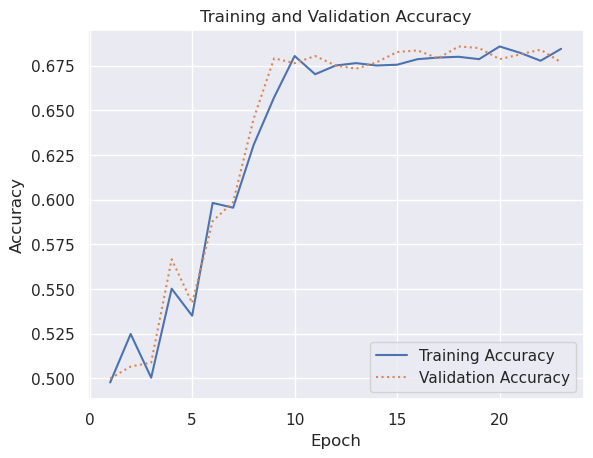

In [99]:
# Plot Training/Validation Accuracy
sns.set()
acc = fitmodel.history['accuracy']
val = fitmodel.history['val_accuracy']
epochs = range = range(1, len(acc)+1)

plt.plot(epochs, acc, '-', label = "Training Accuracy")
plt.plot(epochs, val, ':', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.plot()

In [101]:
# Save model
model.save('model.h5')
model = keras.models.load_model('model.h5')
model

/home/7d515a27-500e-49a7-accc-3e4f4339db24/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
